<a href="https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

In [ ]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [ ]:
import neural_processes

In [ ]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [ ]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [ ]:
batch_size = 16
max_num_context = 50
x_size = 1
y_size = 1
l_length = 0.6
sigma_length = 1.
num_iter = 10001
save_iter = 1000

In [ ]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, l_length, sigma_length, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

In [ ]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves()]

In [ ]:
in_features = 1 
h_size = 128
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 
mc_size = 1

In [ ]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_mu): Linear(in_features=1024, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=1024, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [ ]:
opt = optim.Adam(np.parameters(), lr=5e-5) 

Iteration: 0, loss: 11.85389232635498


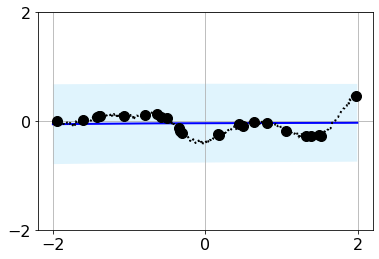

Iteration: 1000, loss: 0.7990963459014893


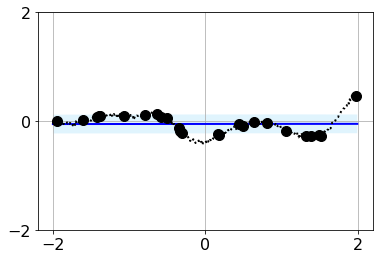

Iteration: 2000, loss: -4.477667808532715


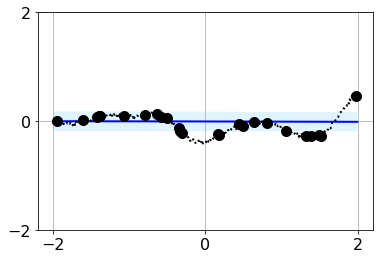

Iteration: 3000, loss: -0.28295040130615234


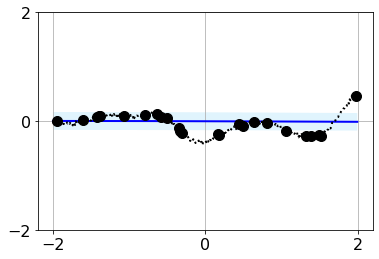

Iteration: 4000, loss: 14.126479148864746


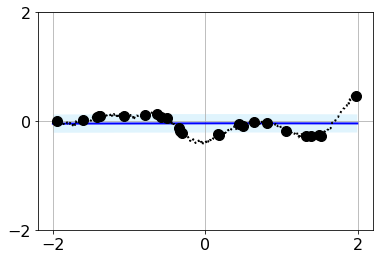

Iteration: 5000, loss: -2.8364553451538086


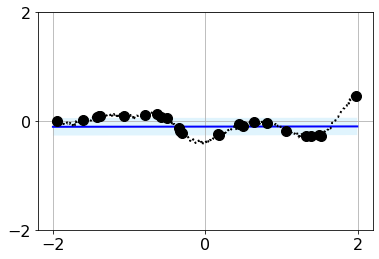

Iteration: 6000, loss: -11.17148494720459


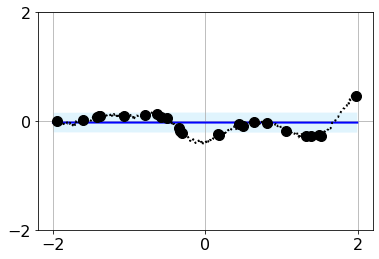

Iteration: 7000, loss: 9.848689079284668


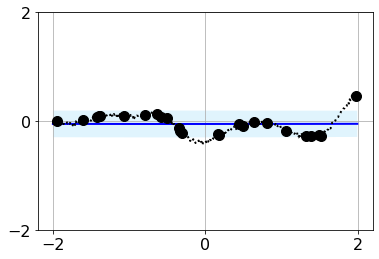

Iteration: 8000, loss: 12.867879867553711


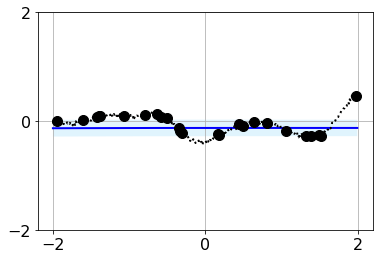

Iteration: 9000, loss: 1.8870407342910767


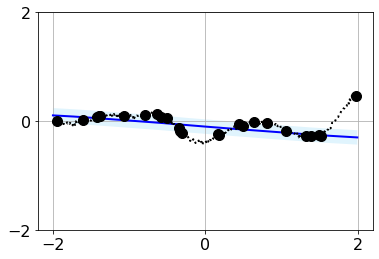

Iteration: 10000, loss: -3.954042911529541


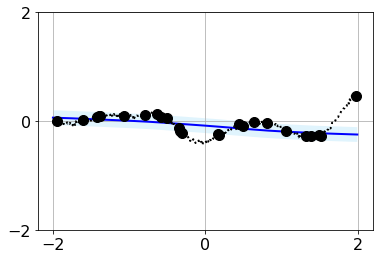

In [ ]:
mu, sigma = neural_processes.utils.fit(num_iter, save_iter, np, opt, train_list, test_list)

In [ ]:
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
params = {'batch_size': 2,
          'shuffle': False,
          'num_workers': 4}

In [ ]:
training_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [ ]:
a = torch.rand(2, 3, 2)
b = a[0]
c = a[1]
b == c

tensor([[False, False],
        [False, False],
        [False, False]])

In [ ]:
for _ in range(2):
  for local_batch, local_labels in training_generator:
    local_batch, local_labels = local_batch.to('cpu'), local_labels.to('cpu')
    print(local_batch.shape)
    print(local_batch[0] == local_batch[1])
    break
  break

torch.Size([2, 1, 28, 28])
tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,

In [ ]:
x, y, xt, yt = test_list[0]

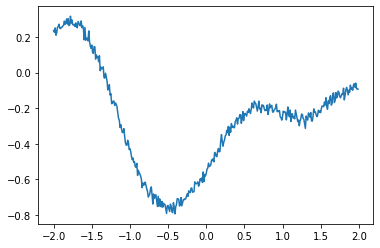

In [ ]:
with torch.no_grad():
    plt.plot(xt.cpu()[0, :, 0], yt.cpu()[0, :, 0])

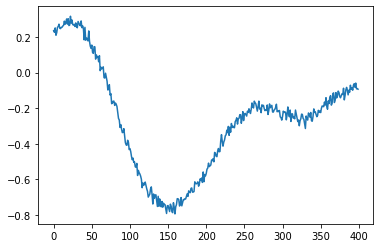

In [ ]:
plt.plot(yt.squeeze().cpu().detach())

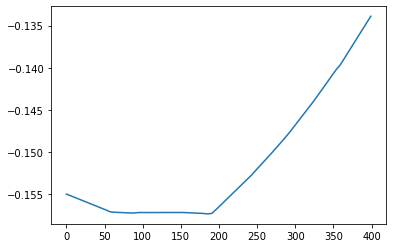

In [ ]:
plt.plot(mu[0].cpu().detach())

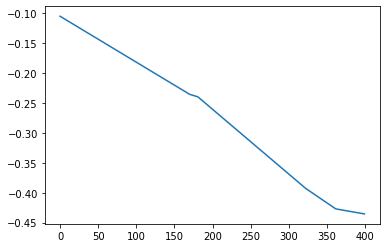

In [ ]:
plt.plot(mu.squeeze())

In [ ]:
x.shape, y.shape, xt.shape, yt.shape

(torch.Size([16, 36, 1]),
 torch.Size([16, 36, 1]),
 torch.Size([16, 37, 1]),
 torch.Size([16, 37, 1]))

In [ ]:
break

In [ ]:
(mu, sig, distr), q = np(x, y, xt, yt)

In [ ]:
mu.shape, sig.shape, distr

(torch.Size([16, 10, 37, 1]),
 torch.Size([16, 10, 37, 1]),
 Normal(loc: torch.Size([16, 10, 37, 1]), scale: torch.Size([16, 10, 37, 1])))

In [ ]:
yt.shape

torch.Size([16, 37, 1])

In [ ]:
yt = yt[:, None, :, :].expand(-1, 10, -1, -1)
distr.log_prob(yt).sum(dim=2, keepdims=True).mean(dim=1).shape
distr.log_prob(yt).mean(dim=1) - distributions.kl_divergence(prior, posterior)

In [ ]:
yt.shape

torch.Size([16, 10, 37, 1])

In [ ]:
distr.log_prob(yt).mean(dim=1, keepdims=True).shape

torch.Size([16, 1, 37, 1])

In [ ]:
prior, posterior = q[0], q[1]

In [ ]:
distr.log_prob(yt).sum(dim=2).mean(dim=1).shape

torch.Size([16, 1])

In [ ]:
r = distr.log_prob(yt).sum(dim=2).mean(dim=1) - distributions.kl_divergence(prior, posterior)

In [ ]:
r.shape

torch.Size([16, 16])

In [ ]:
x.shape, y.shape

(torch.Size([14, 1]), torch.Size([14, 1]))

In [ ]:
x = torch.rand(2, 4, 1)
y = torch.rand(2, 4, 1)
mu, sig, d = np._encoder(x, y)

In [ ]:
mu.shape, sig.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [ ]:
sig.diag_embed().tril()

tensor([[[0.5865, 0.0000, 0.0000],
         [0.0000, 0.5026, 0.0000],
         [0.0000, 0.0000, 0.5089]],

        [[0.5879, 0.0000, 0.0000],
         [0.0000, 0.5027, 0.0000],
         [0.0000, 0.0000, 0.5094]]], grad_fn=<TrilBackward>)

In [ ]:
d2 = distributions.MultivariateNormal(mu, sig.diag_embed().tril())

In [ ]:
d

Normal(loc: torch.Size([2, 3]), scale: torch.Size([2, 3]))

In [ ]:
d2

MultivariateNormal(loc: torch.Size([2, 3]), covariance_matrix: torch.Size([2, 3, 3]))

In [ ]:
d.sample([2]).shape

torch.Size([2, 2, 3])

In [ ]:
d2.sample([2]).shape

torch.Size([2, 2, 3])

In [ ]:
z = d.sample([2])
z

tensor([[[-0.3735, -0.0674, -0.1993],
         [-0.0414,  0.0989,  0.8341]],

        [[ 0.4983, -0.3781,  0.0610],
         [-0.0983,  0.0921, -1.3146]]])

In [ ]:
print(z.shape)

torch.Size([2, 2, 3])


In [ ]:
z = z[:, :, None, :].expand(-1, 2, 4, -1)
z

tensor([[[[-0.3735, -0.0674, -0.1993],
          [-0.3735, -0.0674, -0.1993],
          [-0.3735, -0.0674, -0.1993],
          [-0.3735, -0.0674, -0.1993]],

         [[-0.0414,  0.0989,  0.8341],
          [-0.0414,  0.0989,  0.8341],
          [-0.0414,  0.0989,  0.8341],
          [-0.0414,  0.0989,  0.8341]]],


        [[[ 0.4983, -0.3781,  0.0610],
          [ 0.4983, -0.3781,  0.0610],
          [ 0.4983, -0.3781,  0.0610],
          [ 0.4983, -0.3781,  0.0610]],

         [[-0.0983,  0.0921, -1.3146],
          [-0.0983,  0.0921, -1.3146],
          [-0.0983,  0.0921, -1.3146],
          [-0.0983,  0.0921, -1.3146]]]])

In [ ]:
x.shape, z.shape

(torch.Size([2, 4, 1]), torch.Size([2, 2, 4, 3]))

In [ ]:
x[None, :, :, :].expand(2, -1, -1, -1)

tensor([[[[0.2356],
          [0.8175],
          [0.7516],
          [0.6727]],

         [[0.3648],
          [0.4258],
          [0.1362],
          [0.3602]]],


        [[[0.2356],
          [0.8175],
          [0.7516],
          [0.6727]],

         [[0.3648],
          [0.4258],
          [0.1362],
          [0.3602]]]])

In [ ]:
z = z.permute(1, 0, 2, 3)
z.shape

torch.Size([2, 2, 4, 3])

In [ ]:
torch.cat((x[None, :, :, :].expand(2, -1, -1, -1), z), dim=-1)

tensor([[[[ 0.2356, -0.3735, -0.0674, -0.1993],
          [ 0.8175, -0.3735, -0.0674, -0.1993],
          [ 0.7516, -0.3735, -0.0674, -0.1993],
          [ 0.6727, -0.3735, -0.0674, -0.1993]],

         [[ 0.3648,  0.4983, -0.3781,  0.0610],
          [ 0.4258,  0.4983, -0.3781,  0.0610],
          [ 0.1362,  0.4983, -0.3781,  0.0610],
          [ 0.3602,  0.4983, -0.3781,  0.0610]]],


        [[[ 0.2356, -0.0414,  0.0989,  0.8341],
          [ 0.8175, -0.0414,  0.0989,  0.8341],
          [ 0.7516, -0.0414,  0.0989,  0.8341],
          [ 0.6727, -0.0414,  0.0989,  0.8341]],

         [[ 0.3648, -0.0983,  0.0921, -1.3146],
          [ 0.4258, -0.0983,  0.0921, -1.3146],
          [ 0.1362, -0.0983,  0.0921, -1.3146],
          [ 0.3602, -0.0983,  0.0921, -1.3146]]]])

In [ ]:
x = torch.rand(3, 4, 1)
y = torch.rand(3, 4, 1)
xt = torch.rand(3, 5, 1)
yt = torch.rand(3, 5, 1)

In [ ]:
p = np._encoder(x, y)
q = np._encoder(xt, yt)

In [ ]:
p

Normal(loc: torch.Size([3, 3]), scale: torch.Size([3, 3]))

In [ ]:
q

Normal(loc: torch.Size([3, 3]), scale: torch.Size([3, 3]))

In [ ]:
distributions.kl_divergence(p, q)

tensor([[2.4852e-06, 3.8621e-05, 1.0211e-05],
        [3.4142e-04, 7.5310e-05, 3.1185e-04],
        [5.9038e-04, 2.5520e-04, 6.9835e-04]], grad_fn=<MulBackward0>)

In [ ]:
z = q.sample([2])
z

tensor([[[-0.3538, -0.4964, -0.6820],
         [-0.6174,  0.4985, -0.3972],
         [-0.5295,  0.6884,  0.3467]],

        [[-0.3209, -0.0048,  0.1731],
         [ 0.4810, -0.6156,  0.2947],
         [ 0.4999,  0.5842, -0.5677]]])

In [ ]:
z.shape, xt.shape

(torch.Size([2, 3, 3]), torch.Size([3, 5, 1]))

In [ ]:
z = z[:, :, None, :].expand(-1, -1, xt.shape[1], -1)

In [ ]:
z.shape

torch.Size([3, 2, 5, 3])

In [ ]:
z = z.permute(1, 0, 2, 3)

In [ ]:
xt.shape

torch.Size([3, 5, 1])

In [ ]:
#z = z[:, :, None, :].expand(-1, -1, xt.shape[1], -1)
xt = xt[:, None, :, :].expand(-1, 2, -1, -1)

In [ ]:
xt.shape, z.shape

(torch.Size([3, 2, 5, 1]), torch.Size([3, 2, 5, 3]))

In [ ]:
np(x, y, xt, yt)

In [ ]:
xt

tensor([[[[0.5739],
          [0.1020],
          [0.5454],
          [0.3878],
          [0.3258]],

         [[0.5739],
          [0.1020],
          [0.5454],
          [0.3878],
          [0.3258]]],


        [[[0.2798],
          [0.9200],
          [0.1443],
          [0.8258],
          [0.7651]],

         [[0.2798],
          [0.9200],
          [0.1443],
          [0.8258],
          [0.7651]]],


        [[[0.7097],
          [0.7061],
          [0.4217],
          [0.8048],
          [0.5592]],

         [[0.7097],
          [0.7061],
          [0.4217],
          [0.8048],
          [0.5592]]]])

In [ ]:
xz = torch.cat((xt, z), dim=-1)

tensor([[[[ 0.5739, -0.3538, -0.4964, -0.6820],
          [ 0.1020, -0.3538, -0.4964, -0.6820],
          [ 0.5454, -0.3538, -0.4964, -0.6820],
          [ 0.3878, -0.3538, -0.4964, -0.6820],
          [ 0.3258, -0.3538, -0.4964, -0.6820]],

         [[ 0.5739, -0.3209, -0.0048,  0.1731],
          [ 0.1020, -0.3209, -0.0048,  0.1731],
          [ 0.5454, -0.3209, -0.0048,  0.1731],
          [ 0.3878, -0.3209, -0.0048,  0.1731],
          [ 0.3258, -0.3209, -0.0048,  0.1731]]],


        [[[ 0.2798, -0.6174,  0.4985, -0.3972],
          [ 0.9200, -0.6174,  0.4985, -0.3972],
          [ 0.1443, -0.6174,  0.4985, -0.3972],
          [ 0.8258, -0.6174,  0.4985, -0.3972],
          [ 0.7651, -0.6174,  0.4985, -0.3972]],

         [[ 0.2798,  0.4810, -0.6156,  0.2947],
          [ 0.9200,  0.4810, -0.6156,  0.2947],
          [ 0.1443,  0.4810, -0.6156,  0.2947],
          [ 0.8258,  0.4810, -0.6156,  0.2947],
          [ 0.7651,  0.4810, -0.6156,  0.2947]]],


        [[[ 0.7097, -0.5295,

In [ ]:
mu, sig, distr = np._decoder(xt, z)

In [ ]:
distributions.kl_divergence(p, q).shape

torch.Size([3, 3])

In [ ]:
x, y, xt, yt = train_list[0]
# (mu, sigma, distr), q = np(x, y, xt)

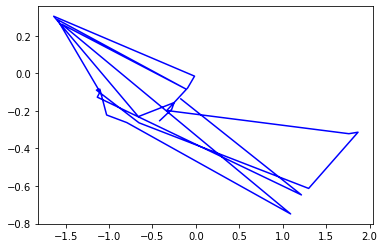

In [ ]:
plt.plot(x.cpu(), y.cpu(), 'b')

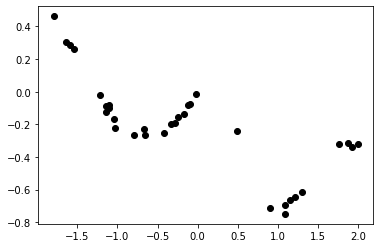

In [ ]:
plt.plot(xt.cpu(), yt.cpu(), 'ko')

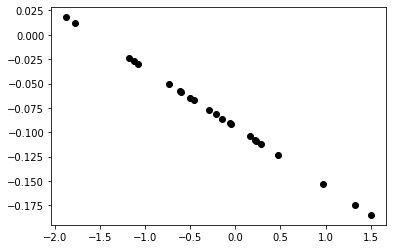

In [ ]:
with torch.no_grad():
  plt.plot(xt.cpu(), mu.mean(dim=0).cpu(), 'ko')

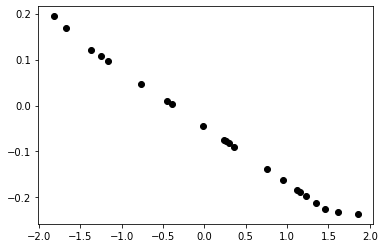

In [ ]:
with torch.no_grad():
  plt.plot(xt.cpu(), mu[10].cpu(), 'ko')

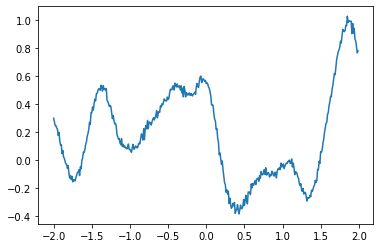

In [ ]:
with torch.no_grad():
  plt.plot(test_list[2].cpu(), test_list[3].cpu())

ValueError: ignored

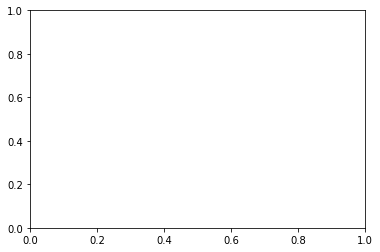

In [ ]:
with torch.no_grad():
  plt.plot(test_list[2].cpu(), mu[0].cpu())

In [ ]:
sigma[0].shape

In [ ]:
plt.plot(sigma[0].cpu().detach())

In [ ]:
plt.plot(yt1)
plt.plot(mu.mean(dim=0))

In [ ]:
mu.mean(dim=1)

In [ ]:
x, y, xt, yt = train_list[0]
(mu, sig, distr), q = np(x, y, xt, yt)
kl = distributions.kl_divergence(q[1], q[0])

In [ ]:
x1, y1, xt1, yt1 = test_list

In [ ]:
(mu, sig, distr), q = np(x1, y1, xt1)

In [ ]:
mu[0].shape

In [ ]:
yt1.shape

In [ ]:
mplt.plot(yt1)

In [ ]:
mu.mean(dim=0)

In [ ]:
plt.plot(mu.detach().mean(dim=0))

In [ ]:
plt.plot(xt, yt, 'k:')
plt.plot(x, y, 'ko', markersize=10)